In [79]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split


'''
Step 1: Split the dataset into training and testing sets
'''

# Creating Yes Sarcasm DataFrame
sarcasm_audio_files = glob.glob("audio_extracted_yes/*.mp3", recursive=True)
sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm", "index"])
sarcasm_audio_df["audio"] = sarcasm_audio_files 
sarcasm_audio_df["sarcasm"] = True
for index, row in sarcasm_audio_df.iterrows():
    val = row["audio"]
    idx1 = val.index("audio_extracted_yes/")
    idx2 = val.index(".mp3")
    res = val[idx1 + len("audio_extracted_yes/"): idx2]
    sarcasm_audio_df['index'].iloc[index]= res

# Creating Not Sarcasm DataFrame
not_sarcasm_audio_files = glob.glob("audio_extracted_no/*.mp3", recursive=True)
not_sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm", "index"])
not_sarcasm_audio_df["audio"] = not_sarcasm_audio_files 
not_sarcasm_audio_df["sarcasm"] = False
for index, row in not_sarcasm_audio_df.iterrows():
    val = row["audio"]
    idx1 = val.index("audio_extracted_no/")
    idx2 = val.index(".mp3")
    res = val[idx1 + len("audio_extracted_no/"): idx2]
    not_sarcasm_audio_df['index'].iloc[index]= res

#Splitting Dataset 70% training 30% testing
x_sarcasm_train, x_sarcasm_test, y_sarcasm_train, y_sarcasm_test = train_test_split(sarcasm_audio_df.drop(columns=['sarcasm']), sarcasm_audio_df["sarcasm"], test_size = 0.3)
x_not_sarcasm_train, x_not_sarcasm_test, y_not_sarcasm_train, y_not_sarcasm_test = train_test_split(not_sarcasm_audio_df.drop(columns=["sarcasm"]), not_sarcasm_audio_df["sarcasm"], test_size = 0.3)

#Concat Sarcasm and Not Sarcasm Dataframe
x_train = pd.concat([x_sarcasm_train, x_not_sarcasm_train])
x_test = pd.concat([x_sarcasm_test, x_not_sarcasm_test])
y_train = pd.concat([y_sarcasm_train, y_not_sarcasm_train])
y_test = pd.concat([y_sarcasm_test, y_not_sarcasm_test])

#Reset Index to start with Index 0
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#Print Len to check if correctly splitted
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

482
208
482
208


/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_35153/425588595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_audio_df['index'].iloc[index]= res
/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_35153/425588595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_audio_df['index'].iloc[index]= res
/var/folders/wp/6pf9hfdx0sj1ny27r16znvwc0000gn/T/ipykernel_35153/425588595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

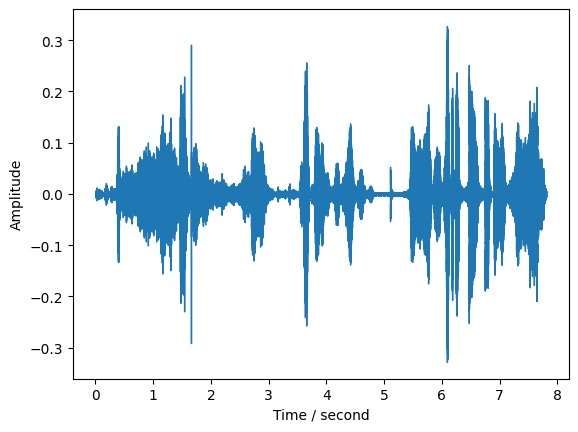

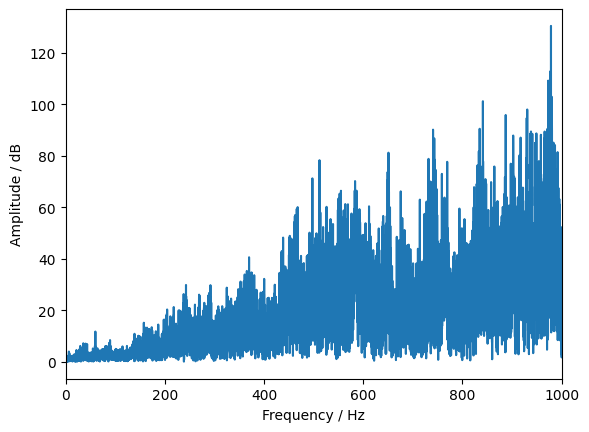

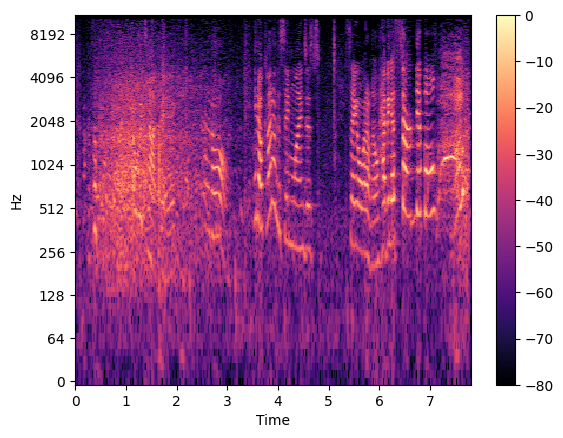

In [80]:
'''
Step 2: Exploratory Data Analysis
'''

from IPython.display import Audio

# plot audio files in time domain
signal, sample_rate = librosa.load(x_train.iloc[0]["audio"])
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()


# plot the time-frequency variation of the audio
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

Audio(data=signal ,rate=sample_rate)

In [81]:
'''
Step 3: Acoustic Feature Extraction 
&
Step 4: Feature Post-processing
'''

from sklearn.preprocessing import MinMaxScaler
numWindow = 20
scale = MinMaxScaler(feature_range=(-1,1))
def feature_extractor(audio_file):
    signal, sample_rate = librosa.load(audio_file)
    
    # audio feature extraction: loudness
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    df_loudness['Loudness'] = scale.fit_transform(pd.DataFrame(df_loudness['Loudness']))

    # audio feature extraction: mel-frequency cepstral coefficients
    df_mfccs = pd.DataFrame()
    # print(df_mfccs)
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc= numWindow)
    for n_mfcc in range(len(mfccs)):
        if(len(mfccs[n_mfcc]) < numWindow):
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = librosa.util.pad_center(mfccs[n_mfcc], size = numWindow, mode='constant').T
        else:
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = scale.fit_transform(pd.DataFrame(df_mfccs['MFCC_%d'%(n_mfcc+1)]))


    # audio feature extraction: zero crossing rate
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    df_zero_crossing_rate['ZCR'] = scale.fit_transform(pd.DataFrame(df_zero_crossing_rate['ZCR']))

    # audio feature extraction: chroma
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, n_chroma=numWindow)
    for n_chroma in range(len(chromagram)):
        if len(chromagram[n_chroma]) < numWindow:
            df_chroma['Chroma_%d'%(n_chroma+1)] = librosa.util.pad_center(chromagram[n_chroma], size = numWindow, mode='constant')
        else:
            df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
        df_chroma['Chroma_%d'%(n_chroma+1)] = scale.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

    # audio feature extraction: mel spectrogram
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=numWindow)
    for n_mel in range(len(mel_spectrogram)):
        if len(mel_spectrogram[n_mel]) < numWindow:
            df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = librosa.util.pad_center(mel_spectrogram[n_mel], size = numWindow, mode='constant').T
        else:
            df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]= scale.fit_transform(pd.DataFrame(df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]))

    # combine all features
    feature_matrix = pd.concat([df_loudness.head(numWindow), df_mfccs, df_zero_crossing_rate.head(numWindow), df_chroma, df_mel_spectrogram], axis=1)
    feature_matrix['mean'] = feature_matrix.mean(axis=1)

    return feature_matrix['mean']


x_train_df = pd.DataFrame(columns=['features', 'index'])
tempFeature = []
indexArray= []
for index, row in x_train.iterrows():
    # print(row['audio'])
    # row = x_train.iloc[val]
    # x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
    tempFeature.append(np.array(feature_extractor(row['audio'])))
    indexArray.append(row['index'])
x_train_df['features'] = tempFeature
x_train_df['index'] = indexArray
x_train = x_train_df
print(x_train)

x_test_df = pd.DataFrame(columns=['features', 'index'])
tempFeature = []
indexArray= []
for index, row in x_test.iterrows():
    # x_test_df = x_test_df.append(feature_extractor(row), ignore_index=True)
    # x_test_df = pd.concat([x_test_df, pd.DataFrame([feature_extractor(row)])], ignore_index=True)
    tempFeature.append(np.array(feature_extractor(row['audio'])))
    indexArray.append(row['index'])
x_test_df['features'] = tempFeature
x_test_df['index'] = indexArray
x_test = x_test_df

# print(x_train)
print(x_test)


                                              features   index
0    [-0.5088271505579971, 0.21809404204464783, 0.1...    2440
1    [-0.37578918732181266, 0.09464709564546864, -0...    2126
2    [-0.6616361384084197, 0.2429183924801176, 0.01...    2420
3    [-0.16409671033770573, 0.18533841181912367, -0...    2109
4    [-0.18457077515663725, 0.0892903431344831, -0....   14760
..                                                 ...     ...
477  [-0.6646822979377264, 0.07346294852994797, -0....  110190
478  [-0.2363876136935206, 0.6207892300443245, -0.1...   16627
479  [-0.7290723709329057, 0.027572867864889182, -0...    2146
480  [-0.7330171064846038, -0.1350200461147418, -0....     269
481  [-0.42959843888273236, 0.3108960573091011, -0....  112083

[482 rows x 2 columns]
                                              features   index
0    [-0.3560644953107037, 0.5081750677627008, -0.1...    2447
1    [-0.16220355339467907, -0.09228588346481453, -...    2373
2    [-0.7842394347981833, -0.0

In [83]:
x = pd.concat([x_train, x_test], axis=0)
y = pd.DataFrame(columns=["sarcasm"])
y["sarcasm"] = pd.concat([y_train, y_test], axis = 0)
final = pd.concat([x, y], axis = 1)
print(final)

final.to_csv('audio_sarcasm_extraction.csv')

                                              features   index  sarcasm
0    [-0.5088271505579971, 0.21809404204464783, 0.1...    2440     True
1    [-0.37578918732181266, 0.09464709564546864, -0...    2126     True
2    [-0.6616361384084197, 0.2429183924801176, 0.01...    2420     True
3    [-0.16409671033770573, 0.18533841181912367, -0...    2109     True
4    [-0.18457077515663725, 0.0892903431344831, -0....   14760     True
..                                                 ...     ...      ...
203  [-0.22316940679880018, 0.4814944739602955, 0.1...    2107    False
204  [-0.49817211931890926, 0.3342537726191028, -0....  112002    False
205  [-0.734228746122305, 0.15540760363693812, -0.0...     249    False
206  [-0.34830858592572683, -0.11108223161474869, -...   12361    False
207  [-0.3192149981115324, 0.3212631820140589, 0.04...    2400    False

[690 rows x 3 columns]


In [17]:
'''
Step 5: Build your audio emotion recognition model
'''

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

svc.fit(x_train, y_train)
nbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [18]:
y_svc_predicted = svc.predict(x_test)
print(classification_report(y_test, y_svc_predicted))

y_nbc_predicted = nbc.predict(x_test)
print(classification_report(y_test, y_nbc_predicted))

y_rfc_predicted = rfc.predict(x_test)
print(classification_report(y_test, y_rfc_predicted))

              precision    recall  f1-score   support

       False       0.58      0.64      0.61       104
        True       0.60      0.54      0.57       104

    accuracy                           0.59       208
   macro avg       0.59      0.59      0.59       208
weighted avg       0.59      0.59      0.59       208

              precision    recall  f1-score   support

       False       0.57      0.74      0.64       104
        True       0.63      0.44      0.52       104

    accuracy                           0.59       208
   macro avg       0.60      0.59      0.58       208
weighted avg       0.60      0.59      0.58       208

              precision    recall  f1-score   support

       False       0.53      0.54      0.53       104
        True       0.53      0.52      0.52       104

    accuracy                           0.53       208
   macro avg       0.53      0.53      0.53       208
weighted avg       0.53      0.53      0.53       208

